# Investigation 01: Spreading Factor Assignment Strategy for Coverage and Capacity Flexible trade-off

### Authors : Luiz (UFJF), Álvaro (UFJF), Jessika (UFRN), Vicente Sousa (UFRN)

**Targets:**
- HOWTO material to download, configure and compile the code;
- HOWTO material to create, run and plot simulations results (including Python scripts);
- Preliminaly analyses of simulation results.


# Getting started


### Download Process

- To download this repository, please, type in the terminal:

```bash
git clone https://github.com/vicentesousa/ns-3-lora-gppcom.git
```

- To go to the code directory, please, type:

```bash
cd ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/
```
- To configure, type:

```bash
CXXFLAGS="-Wall -g -O0" ./waf --build-profile=debug --disable-examples --disable-tests --disable-python configure
```

- To compile, type:

```bash
./waf
```

### Manual installation (optional)

The script **ns3_full_installation.sh** was built to automatically install the code following the three steps:
- Download and solve the dependences;
- Download the ns-3.29 code;
- Download the LoRaWAN ns-3 module (from **https://github.com/signetlabdei/lorawan**) 
- Merge codes from ns-3.29 and LoRaWAN ns-3 module repositories;
- Add ur changes with new ADR codes (from **LoRa-Luiz-vicente** folder).

The script **ns3_full_installation.sh** should be called inside the folder **ns-3-lora-gppcom** (directory of this repository). However, this script has already been executed, with all contents generated and commited into the repository. So, for sake of simplicity, you do not need to repeat its execution every repository clonning.

# Simulation Campaings (creation, run and plot)

Our processo to create, run and plot a simulation campaign is completely based on **yaml** files. In this file, a set of parameters is definied as well as the target parameter to a **parametric evaluation**. Such parametric evaluation allows for the analyses of the LoRaWAN metrics in function of the defined range of the target parameter.

The **yaml** file will be used by to Python functions: the **plotScript.py**, which generates all auxiliary files to run simulations; and **plotScript.py**, which plots the simulation results.

Herein, we provide two campaigns we used to perform the proof-of-concept simulations of our ADR proposal. They are:

- **nDevices** campaign with the following parameters:
   - nDevices (target parameter): 1000, 2000, 3000, 4000, 5000, 6000;
   - radius: 3000

- **radius** campaign with the following parameters:
   - radius (target parameter): 2000, 4000, 6000, 8000, 10000;
   - nDevices: 3000 

**Attention**: maybe you need to specify the **ns3_path** (with our complete path) to run simulation in our local machine.


### Campaign Criation

To configure the simulation campaign and create **ADR_campaign.yaml** file, run the following code. We set a number of 20 simulation runs to get statiscal confidence of performance metrics. 

In [14]:
%%file ADR_campaign.yaml
scenario:
    # Output filename
    filename: CampaignLoraWAN
    # Set location of simulation: local or cluster
    simLocation: local
    # Set campaign scenario: a name of one valid parameter
    #campaign: radius
    # Set campaign scenario: a name of one valid parameter
    #campaignX: name of parameter to vary in the X-axis
    #campaignLines: name of parameter to vary in different lines
    campaignX: 
        - radius
        - nDevices
    campaignLines: 
        - Algoritmo
    # Number of jobs to run
    jobs: 20
    # Simulation duration (seconds)
    simulationTime: 600
    # Number of end devices to include in the simulation
    nDevices:
        - 3000
        - 1000
        - 2000 
        - 4000
        - 5000
        - 6000 
    # The radius of the area to simulate
    radius: 
        - 3000
        - 2000
        - 4000
        - 6000
        - 8000
        - 10000
    # The period in seconds to be used by periodically transmitting applications
    appPeriodSeconds: 600
    # Whether or not to print various informations
    bPrint: false
    # Fixed seed and run seed (set false for a long simulation campaign)
    fixedSeed: false
    # Algoritmo de ADR: 1 to 5
    Algoritmo: 
        - 1
        - 2
        - 3
        - 4
        - 5
        - 8
    # Target realocation for Algorithm 7
    targetRealocation:
        - 0
    # Complete path of ns-3 simulator
    ns3_path: ns-new-implementation/ns-3.29
    # Script with the main code (inside scratch folder without .cc)
    ns3_script: ADR_code

Overwriting ADR_campaign.yaml


A seguinte função em python foi criada para, de posse do arquivo **yaml**, criar um arquivo **.sh** para rodar a campanha de simulação.  Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **loraScript.py** é gerado.

In [7]:
%%file loraScript.py
from collections import defaultdict
import os
import math
import random
import re
import subprocess
import sys
import argparse
from glob import glob
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
# To install YAML: sudo apt-get install python3-yaml
import yaml

class Simulation:
    def __init__(self, configurations_file):
        #self.email_to = 'sicrano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.campaignX = self.doc['scenario']['campaignX']
        self.campaignLines = self.doc['scenario']['campaignLines'][0]
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices'][0]
        self.radius = self.doc['scenario']['radius'][0]
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo'][0]
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        self.targetRealocation  = (self.doc['scenario']['targetRealocation'])[0]
        self.filename = str(self.doc['scenario']['filename'])
        self.configurations_file = configurations_file
       
    def runCampaign(self,curCampaign):
        # Configure simulation file in accordance with campaign parameter
        sh_name = self.campaign_name + '_' + self.simLocation + '_' + curCampaign
        print(curCampaign+" campaign written in file: " 'run_%s.sh' % sh_name)
        with open('run_%s.sh' % sh_name, 'w') as f:                    
            if self.simLocation == 'cluster':
              print('To be implemented')
            else:
              f.write('#!/bin/bash\n')
              outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign
              f.write('rm -rf '+outputDir+' 2>/dev/null\n')
              f.write('mkdir -p '+outputDir+'\n')
              f.write('cp -f run_'+sh_name+'.sh'+' '+outputDir+'\n')
              f.write('cp -f '+self.configurations_file+ ' ' +outputDir+'\n')
              f.write("cd '"+self.ns3_path+"'"+"\n")
                
            for iJob in range(0, self.nJobs):
                jobRunSeed = random.randint(1, 23*10**14)
                #for iAlg in self.algoritmo:                           
                for curLine in self.doc['scenario'][self.campaignLines]:                           
                    for varParam in self.doc['scenario'][curCampaign]:
                        command = (
                        'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                        "./waf --run '"+self.ns3_script+
                        " --radius="+self.radius+
                        " --nDevices="+self.nDevices+
                        " --simulationTime="+self.simulationTime+
                        " --appPeriodSeconds="+self.appPeriodSeconds+
                        " --print="+self.bPrint+
                        " --fixedSeed="+str(self.fixedSeed)+
                        " --algoritmo="+self.algoritmo+
                        " --filename="+ self.filename +
                        " --outputDir='"+outputDir+"'"
                        " --"+self.campaignLines+"="+curLine+
                        " --"+curCampaign+"="+varParam+
                        "'"
                        )
                        f.write(command+' & wait\n')
                      
parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

print('Simulação escolhida: ')
campaign = doc['scenario']['campaignX']
print(campaign)
                 
simu = Simulation(configurations_file)

for simC in campaign:
    if str(simC) == 'nDevices' or str(simC) == 'radius' or str(simC) == 'targetRealocation':
        simu.runCampaign(simC);
    else:
        print('Invalid simulation campaign: verify the campaign parameter!')

Overwriting loraScript.py


O Script **loraScript.py** recebe um arquivo **yaml** com parâmetro de entrada e gera os segugintes arquivos:

- **run_campanha_local_nDevices.sh**: com as chamadas para as simulações variando o número de dispositivos;
- **run_campanha_local_radius.sh**: com as chamadas para as simulações variando o raio.

Esses dois arquivos **.sh** devem ser chamados em um terminal, chamando as simulações especificas de cada caso.

Abaixo, o script **loraScript.py** é chamado para a **campanha_1.yaml** criada anteriormente.


In [8]:
%run loraScript -f "ADR_campaign.yaml"

Simulação escolhida: 
['radius', 'nDevices']
radius campaign written in file: run_ADR_campaign_local_radius.sh
nDevices campaign written in file: run_ADR_campaign_local_nDevices.sh


Para rodar o código em um terminal, digite:

```python
python3 loraScript.py -f 'ADR_campaign.yaml'
```


Ao rodar o **loraScript.py** com o arquivo **campanha_1.yaml** como parâmetro, os arquivos  **run_all_campanha_1_local_nDevices.sh** e **run_all_campanha_1_local_radius.sh** foram criados. Eles contém a chamada de código para as duas campanhas de simulação especificadas em **campanha_1.yaml**.

O código a seguir executa os dois arquivos **.sh** diretamente deste Jupyter Notebook.

In [7]:
!chmod +x ./run_ADR_campaign_local_radius.sh
!./run_ADR_campaign_local_radius.sh


!chmod +x ./run_ADR_campaign_local_nDevices.sh
!./run_ADR_campaign_local_nDevices.sh

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.806s)
simulation start at: Wed Feb 19 09:58:18 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4116868799, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 09:59:59 2020

Time elapsed: 1.68333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_command

simulation start at: Wed Feb 19 10:16:19 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4116868799, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:18:00 2020

Time elapsed: 1.68333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.786s)
simulation start at: Wed Feb 19 10:18:03 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4116868799, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 10:35:59 2020

Time elapsed: 1.73333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.803s)
simulation start at: Wed Feb 19 10:36:01 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4116868799, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:37:45 2020

Time elapsed: 1.73333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 10:53:18 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1210512250, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:54:52 2020

Time elapsed: 1.56667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.802s)
simulation start at: Wed Feb 19 10:54:54 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1210512250, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 11:11:57 2020

Time elapsed: 1.65 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.830s)
simulation start at: Wed Feb 19 11:11:59 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1210512250, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 11:13:37 2020

Time elapsed: 1.63333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/v

simulation start at: Wed Feb 19 11:29:00 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1210512250, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 11:30:45 2020

Time elapsed: 1.75 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.747s)
simulation start at: Wed Feb 19 11:30:47 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1210512250, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Wed Feb 19 11:47:35 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Wed Feb 19 11:47:37 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3985746143, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 11:49:00 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 12:01:57 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3985746143, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 12:03:22 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.815s)
simulation start at: Wed Feb 19 12:03:24 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3985746143, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 12:17:45 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.757s)
simulation start at: Wed Feb 19 12:17:47 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3985746143, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 12:19:11 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vi

simulation start at: Wed Feb 19 12:32:06 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 678447626, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 12:33:28 2020

Time elapsed: 1.36667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.731s)
simulation start at: Wed Feb 19 12:33:30 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 678447626, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Computing performance metrics...
simulation finished at: Wed Feb 19 12:47:51 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.733s)
simulation start at: Wed Feb 19 12:47:53 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 678447626, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 12:49:16 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao

simulation start at: Wed Feb 19 13:02:21 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 678447626, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 13:03:59 2020

Time elapsed: 1.63333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.738s)
simulation start at: Wed Feb 19 13:04:00 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 678447626, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Wed Feb 19 13:18:28 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Wed Feb 19 13:18:30 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4151339241, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 13:19:56 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 13:32:54 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4151339241, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 13:34:19 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.719s)
simulation start at: Wed Feb 19 13:34:21 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4151339241, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 13:48:50 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.744s)
simulation start at: Wed Feb 19 13:48:52 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 4151339241, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 13:50:19 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/v

simulation start at: Wed Feb 19 14:03:22 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3785425139, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 14:04:49 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.744s)
simulation start at: Wed Feb 19 14:04:51 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3785425139, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/n

Computing performance metrics...
simulation finished at: Wed Feb 19 14:19:23 2020

Time elapsed: 1.36667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.723s)
simulation start at: Wed Feb 19 14:19:25 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3785425139, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 14:20:52 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/v

simulation start at: Wed Feb 19 14:34:01 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3785425139, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 14:35:26 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.736s)
simulation start at: Wed Feb 19 14:35:28 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3785425139, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 14:50:19 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.727s)
simulation start at: Wed Feb 19 14:50:21 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3782364441, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 14:51:54 2020

Time elapsed: 1.55 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicen

simulation start at: Wed Feb 19 15:05:27 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3782364441, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 15:06:51 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.738s)
simulation start at: Wed Feb 19 15:06:53 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3782364441, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns

Computing performance metrics...
simulation finished at: Wed Feb 19 15:21:26 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.735s)
simulation start at: Wed Feb 19 15:21:28 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1689104036, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 15:22:52 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vi

simulation start at: Wed Feb 19 15:35:58 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1689104036, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 15:37:24 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Wed Feb 19 15:37:26 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1689104036, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 15:51:48 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.736s)
simulation start at: Wed Feb 19 15:51:50 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1689104036, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 15:53:17 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicen

simulation start at: Wed Feb 19 16:06:27 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3641190192, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 16:07:53 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Wed Feb 19 16:07:55 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3641190192, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 16:22:19 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.738s)
simulation start at: Wed Feb 19 16:22:21 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3641190192, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 16:23:49 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/v

simulation start at: Wed Feb 19 16:37:15 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3641190192, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 16:38:40 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.716s)
simulation start at: Wed Feb 19 16:38:42 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3641190192, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 16:53:15 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.733s)
simulation start at: Wed Feb 19 16:53:17 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3919003883, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 16:54:40 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 17:07:55 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3919003883, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 17:09:22 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.739s)
simulation start at: Wed Feb 19 17:09:24 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3919003883, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/n

Computing performance metrics...
simulation finished at: Wed Feb 19 17:24:09 2020

Time elapsed: 1.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.735s)
simulation start at: Wed Feb 19 17:24:11 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3919003883, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 17:25:34 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vi

simulation start at: Wed Feb 19 17:39:12 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 867611698, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 17:40:36 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Wed Feb 19 17:40:38 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 867611698, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-

Computing performance metrics...
simulation finished at: Wed Feb 19 17:55:21 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Wed Feb 19 17:55:23 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 867611698, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 17:56:47 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vic

simulation start at: Wed Feb 19 18:10:02 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 867611698, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 18:11:31 2020

Time elapsed: 1.48333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.752s)
simulation start at: Wed Feb 19 18:11:33 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 867611698, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Wed Feb 19 18:26:13 2020

Time elapsed: 1.48333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.732s)
simulation start at: Wed Feb 19 18:26:15 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3923373661, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 18:27:40 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 18:41:11 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3923373661, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 18:42:37 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.740s)
simulation start at: Wed Feb 19 18:42:39 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3923373661, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 18:57:28 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Wed Feb 19 18:57:30 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3923373661, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 18:58:58 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 19:12:27 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3135636664, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 19:13:52 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.736s)
simulation start at: Wed Feb 19 19:13:54 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3135636664, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 19:28:33 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.723s)
simulation start at: Wed Feb 19 19:28:35 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3135636664, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 19:30:01 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 19:43:49 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3135636664, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 19:45:16 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.755s)
simulation start at: Wed Feb 19 19:45:18 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3135636664, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Wed Feb 19 19:59:57 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.746s)
simulation start at: Wed Feb 19 19:59:59 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2859789091, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 20:01:26 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/v

simulation start at: Wed Feb 19 20:14:48 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2859789091, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 20:16:17 2020

Time elapsed: 1.48333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.726s)
simulation start at: Wed Feb 19 20:16:19 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2859789091, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 20:31:07 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.721s)
simulation start at: Wed Feb 19 20:31:09 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2839349058, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 20:32:43 2020

Time elapsed: 1.56667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 20:46:38 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2839349058, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 20:48:07 2020

Time elapsed: 1.48333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.737s)
simulation start at: Wed Feb 19 20:48:09 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2839349058, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 21:03:20 2020

Time elapsed: 1.63333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.742s)
simulation start at: Wed Feb 19 21:03:22 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2839349058, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 21:04:52 2020

Time elapsed: 1.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vi

simulation start at: Wed Feb 19 21:18:29 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3667667271, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 21:19:59 2020

Time elapsed: 1.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.730s)
simulation start at: Wed Feb 19 21:20:01 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3667667271, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns

Computing performance metrics...
simulation finished at: Wed Feb 19 21:35:00 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.742s)
simulation start at: Wed Feb 19 21:35:02 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3667667271, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 21:36:30 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulaca

simulation start at: Wed Feb 19 21:50:14 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3667667271, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 21:51:42 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.729s)
simulation start at: Wed Feb 19 21:51:44 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3667667271, outputDir = /home/simulacao/vicente/ns-3-lora-gppc

Computing performance metrics...
simulation finished at: Wed Feb 19 22:06:55 2020

Time elapsed: 1.51667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.747s)
simulation start at: Wed Feb 19 22:06:57 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 787835434, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 22:08:23 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao

simulation start at: Wed Feb 19 22:22:04 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 787835434, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 22:23:31 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.745s)
simulation start at: Wed Feb 19 22:23:33 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 787835434, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.737s)
simulation start at: Wed Feb 19 22:38:46 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 787835434, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 22:40:22 2020

Time elapsed: 1.6 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.jso

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 22:55:52 2020

Time elapsed: 1.55 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.737s)
simulation start at: Wed Feb 19 22:55:54 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2729187553, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 22:57:17 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/b

simulation start at: Wed Feb 19 23:10:37 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2729187553, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 23:12:03 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.741s)
simulation start at: Wed Feb 19 23:12:05 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2729187553, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 23:27:01 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Wed Feb 19 23:27:03 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2729187553, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 23:28:36 2020

Time elapsed: 1.55 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving direct

simulation start at: Wed Feb 19 23:41:56 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3161348635, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 23:43:21 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Wed Feb 19 23:43:23 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3161348635, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Computing performance metrics...
simulation finished at: Wed Feb 19 23:58:14 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Wed Feb 19 23:58:16 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3161348635, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 23:59:39 2020

Time elapsed: 1.38333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/

simulation start at: Thu Feb 20 00:13:14 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3161348635, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 00:14:41 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.722s)
simulation start at: Thu Feb 20 00:14:43 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3161348635, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/n

Computing performance metrics...
simulation finished at: Thu Feb 20 00:29:49 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.745s)
simulation start at: Thu Feb 20 00:29:51 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 293291431, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 00:31:19 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao

simulation start at: Thu Feb 20 00:44:56 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 293291431, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 00:46:30 2020

Time elapsed: 1.56667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.719s)
simulation start at: Thu Feb 20 00:46:32 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 293291431, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

simulation finished at: Thu Feb 20 01:01:31 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.743s)
simulation start at: Thu Feb 20 01:01:33 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 293291431, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 01:03:01 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-all

simulation start at: Thu Feb 20 01:21:58 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3117968212, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 01:24:51 2020

Time elapsed: 2.88333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.727s)
simulation start at: Thu Feb 20 01:24:53 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3117968212, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 01:54:56 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.729s)
simulation start at: Thu Feb 20 01:54:58 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3117968212, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 01:55:28 2020

Time elapsed: 0.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dir

simulation start at: Thu Feb 20 02:27:00 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4114631258, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 02:28:32 2020

Time elapsed: 1.53333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.722s)
simulation start at: Thu Feb 20 02:28:34 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4114631258, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 02:53:57 2020

Time elapsed: 4.75 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.731s)
simulation start at: Thu Feb 20 02:53:59 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4114631258, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 03:00:40 2020

Time elapsed: 6.68333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dire

simulation start at: Thu Feb 20 03:19:49 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4114631258, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 03:22:46 2020

Time elapsed: 2.95 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.720s)
simulation start at: Thu Feb 20 03:22:48 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4114631258, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 03:53:07 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.751s)
simulation start at: Thu Feb 20 03:53:09 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2761751998, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 03:53:40 2020

Time elapsed: 0.516667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Thu Feb 20 04:25:16 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2761751998, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 04:26:51 2020

Time elapsed: 1.58333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.727s)
simulation start at: Thu Feb 20 04:26:53 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2761751998, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 04:52:08 2020

Time elapsed: 4.81667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.752s)
simulation start at: Thu Feb 20 04:52:10 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2761751998, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 04:59:16 2020

Time elapsed: 7.1 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving direc

simulation start at: Thu Feb 20 05:18:18 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 308154789, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 05:20:55 2020

Time elapsed: 2.61667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.721s)
simulation start at: Thu Feb 20 05:20:57 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 308154789, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 05:51:25 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Thu Feb 20 05:51:27 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 308154789, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 05:51:57 2020

Time elapsed: 0.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dire

simulation start at: Thu Feb 20 06:23:48 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 308154789, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 06:25:12 2020

Time elapsed: 1.4 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.716s)
simulation start at: Thu Feb 20 06:25:14 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 308154789, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 06:50:34 2020

Time elapsed: 4.81667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.754s)
simulation start at: Thu Feb 20 06:50:36 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3865031964, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 06:57:47 2020

Time elapsed: 7.18333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Thu Feb 20 07:16:24 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3865031964, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 07:19:20 2020

Time elapsed: 2.93333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.732s)
simulation start at: Thu Feb 20 07:19:22 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3865031964, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 07:49:49 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.729s)
simulation start at: Thu Feb 20 07:49:51 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3865031964, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 07:50:26 2020

Time elapsed: 0.583333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Thu Feb 20 08:22:53 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2113304021, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 08:24:25 2020

Time elapsed: 1.53333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.738s)
simulation start at: Thu Feb 20 08:24:27 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2113304021, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 08:50:13 2020

Time elapsed: 4.85 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.736s)
simulation start at: Thu Feb 20 08:50:15 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2113304021, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 08:57:28 2020

Time elapsed: 7.21667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dire

simulation start at: Thu Feb 20 09:16:53 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2113304021, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 09:19:41 2020

Time elapsed: 2.8 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.725s)
simulation start at: Thu Feb 20 09:19:43 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2113304021, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Thu Feb 20 09:50:32 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.733s)
simulation start at: Thu Feb 20 09:50:34 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 481011510, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 09:51:05 2020

Time elapsed: 0.516667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simu

simulation start at: Thu Feb 20 10:23:37 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 481011510, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 10:25:02 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.745s)
simulation start at: Thu Feb 20 10:25:04 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 481011510, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 10:50:28 2020

Time elapsed: 4.56667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.730s)
simulation start at: Thu Feb 20 10:50:30 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 481011510, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 10:57:57 2020

Time elapsed: 7.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving direc

simulation start at: Thu Feb 20 11:17:14 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3288029654, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 11:20:07 2020

Time elapsed: 2.88333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.719s)
simulation start at: Thu Feb 20 11:20:09 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3288029654, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 11:51:00 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.738s)
simulation start at: Thu Feb 20 11:51:02 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3288029654, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 11:51:32 2020

Time elapsed: 0.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dir

simulation start at: Thu Feb 20 12:22:57 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4126506499, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 12:24:22 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.735s)
simulation start at: Thu Feb 20 12:24:24 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4126506499, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 12:49:47 2020

Time elapsed: 4.95 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Thu Feb 20 12:49:49 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4126506499, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 12:57:06 2020

Time elapsed: 7.28333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/

simulation start at: Thu Feb 20 13:17:11 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4126506499, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 13:20:02 2020

Time elapsed: 2.85 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.743s)
simulation start at: Thu Feb 20 13:20:04 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4126506499, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 13:51:13 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.728s)
simulation start at: Thu Feb 20 13:51:15 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2985950249, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 13:51:45 2020

Time elapsed: 0.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dir

simulation start at: Thu Feb 20 14:24:06 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2985950249, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 14:25:31 2020

Time elapsed: 1.41667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Thu Feb 20 14:25:33 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2985950249, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 14:51:10 2020

Time elapsed: 4.86667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.722s)
simulation start at: Thu Feb 20 14:51:12 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2985950249, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 14:58:26 2020

Time elapsed: 7.23333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Thu Feb 20 15:17:14 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3375837376, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 15:20:05 2020

Time elapsed: 2.85 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.746s)
simulation start at: Thu Feb 20 15:20:07 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3375837376, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Computing performance metrics...
simulation finished at: Thu Feb 20 15:51:18 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.745s)
simulation start at: Thu Feb 20 15:51:20 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3375837376, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 15:51:54 2020

Time elapsed: 0.566667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/sim

simulation start at: Thu Feb 20 16:23:28 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3375837376, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 16:24:54 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.741s)
simulation start at: Thu Feb 20 16:24:56 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3375837376, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 16:50:46 2020

Time elapsed: 4.83333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Thu Feb 20 16:50:48 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3312862971, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 16:57:49 2020

Time elapsed: 7.01667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Thu Feb 20 17:17:20 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3312862971, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 17:20:10 2020

Time elapsed: 2.83333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.730s)
simulation start at: Thu Feb 20 17:20:12 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3312862971, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 17:51:07 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.742s)
simulation start at: Thu Feb 20 17:51:09 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3312862971, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 17:51:40 2020

Time elapsed: 0.516667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Thu Feb 20 18:23:59 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3231749163, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 18:25:27 2020

Time elapsed: 1.46667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.723s)
simulation start at: Thu Feb 20 18:25:29 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3231749163, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 18:51:16 2020

Time elapsed: 4.93333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Thu Feb 20 18:51:18 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3231749163, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 18:58:40 2020

Time elapsed: 7.36667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Thu Feb 20 19:18:18 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3231749163, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 19:21:09 2020

Time elapsed: 2.85 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.745s)
simulation start at: Thu Feb 20 19:21:11 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3231749163, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 19:52:08 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.732s)
simulation start at: Thu Feb 20 19:52:10 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2322300217, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 19:52:40 2020

Time elapsed: 0.5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dir

simulation start at: Thu Feb 20 20:25:44 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2322300217, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 20:27:10 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.725s)
simulation start at: Thu Feb 20 20:27:12 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2322300217, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 20:52:29 2020

Time elapsed: 4.78333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.724s)
simulation start at: Thu Feb 20 20:52:31 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2322300217, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 20:59:44 2020

Time elapsed: 7.21667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Thu Feb 20 21:19:14 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2107639057, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 21:22:09 2020

Time elapsed: 2.91667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.737s)
simulation start at: Thu Feb 20 21:22:11 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2107639057, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 21:53:13 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.732s)
simulation start at: Thu Feb 20 21:53:15 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2107639057, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 21:53:47 2020

Time elapsed: 0.533333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Thu Feb 20 22:26:17 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 917730186, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 22:27:43 2020

Time elapsed: 1.43333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.733s)
simulation start at: Thu Feb 20 22:27:45 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 917730186, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 22:54:02 2020

Time elapsed: 5 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.733s)
simulation start at: Thu Feb 20 22:54:04 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 917730186, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 23:01:24 2020

Time elapsed: 7.33333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving director

simulation start at: Thu Feb 20 23:20:43 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 917730186, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 23:23:44 2020

Time elapsed: 3.01667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.747s)
simulation start at: Thu Feb 20 23:23:46 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 917730186, outputDir = /home/simulacao/vicente/ns-3-lora-gppco

Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 23:55:10 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.737s)
simulation start at: Thu Feb 20 23:55:12 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3471437933, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 20 23:55:43 2020

Time elapsed: 0.516667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Fri Feb 21 00:28:00 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3471437933, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 00:29:27 2020

Time elapsed: 1.45 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.725s)
simulation start at: Fri Feb 21 00:29:29 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3471437933, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 00:55:36 2020

Time elapsed: 4.85 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.727s)
simulation start at: Fri Feb 21 00:55:38 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3471437933, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 01:02:33 2020

Time elapsed: 6.91667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving dire

simulation start at: Fri Feb 21 01:22:06 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3183616372, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 01:25:00 2020

Time elapsed: 2.9 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.731s)
simulation start at: Fri Feb 21 01:25:02 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3183616372, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/

Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 01:56:04 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.739s)
simulation start at: Fri Feb 21 01:56:06 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3183616372, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 01:56:41 2020

Time elapsed: 0.583333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

'build' finished successfully (1.737s)
simulation start at: Fri Feb 21 02:29:35 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3183616372, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 02:31:12 2020

Time elapsed: 1.61667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.763s)
simulation start at: Fri Feb 21 02:31:14 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3183616372, outputDir 

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 02:57:01 2020

Time elapsed: 4.96667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.734s)
simulation start at: Fri Feb 21 02:57:03 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4167598625, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 03:04:16 2020

Time elapsed: 7.21667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.

simulation start at: Fri Feb 21 03:24:03 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4167598625, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 03:26:58 2020

Time elapsed: 2.91667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.714s)
simulation start at: Fri Feb 21 03:27:00 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4167598625, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 03:58:07 2020

Time elapsed: 0.0833333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.750s)
simulation start at: Fri Feb 21 03:58:09 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 4167598625, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 03:58:44 2020

Time elapsed: 0.583333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leavin

simulation start at: Fri Feb 21 04:31:18 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1819121659, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 04:32:51 2020

Time elapsed: 1.55 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.722s)
simulation start at: Fri Feb 21 04:32:53 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1819121659, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom

Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 04:58:27 2020

Time elapsed: 4.96667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.730s)
simulation start at: Fri Feb 21 04:58:29 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1819121659, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 05:05:46 2020

Time elapsed: 7.28333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving d

simulation start at: Fri Feb 21 05:25:31 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1819121659, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 21 05:28:21 2020

Time elapsed: 2.83333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.752s)
simulation start at: Fri Feb 21 05:28:23 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1819121659, outputDir = /home/simulacao/vicente/ns-3-lora-gpp

Os arquivos **.sh** acima chamam as simulações uma a uma, guardando o resultados no seguintes arquivos e pastas:

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices**: para simulações variando o parâmetros **nDevices**;
    - **campanha_1_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius**: para simulações variando o parâmetros **radius**;
    - **campanha_1_local_radius.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_radius.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

Abaixo, o script **loraScript.py** é chamado para criar a outra campanha de simulações criada anteriormente (**campanha_2.yaml**).

# Plotar gráficos 

Para plotar gráficos, chamaremos o mesmo arquivo **yaml** que foi usado para criar as campanhas de simulação. Um novo script chamado **plotScript.py** foi construído para esse fim. Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **plotScript.py** é gerado.

In [11]:
%%file plotScript.py
#%%file plotScriptRealoc.py
# Legend
#   RunSeed: 0
#   Seed: 1
#   Algoritmo: 2
#   Radius: 3
#   nDevices: 4
#   appPeriodSeconds:5
#   simulationTime:6
#   PHYTotal: 7
#   PHYSuccessful:8 
#   PHYInterfered: 9
#   PHYNoMoreReceivers: 10
#   PHYUnderSensitivity: 11
#   PHYLostBecauseTX: 12
#   SimulationDuration: 13

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib
from random import randint   
import itertools      

class openSimulation:
    def __init__(self, configurations_file):
        self.email_to = 'fulano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.showPlot = True;
        self.plotCI = True;                
        self.campaignX = self.doc['scenario']['campaignX']
        self.campaignLines = self.doc['scenario']['campaignLines'][0]
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices']
        self.nDevices = list(map(float,self.nDevices))
        self.radius = self.doc['scenario']['radius']
        self.radius = list(map(float,self.radius))
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.Algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        if self.nJobs == 1: # disable the confidence interval
            self.plotCI = False;
        self.filename = str(self.doc['scenario']['filename'])
        self.targetRealocation  = self.doc['scenario']['targetRealocation']
        
    def doLabelAlgoritmo(self, algID):
        # Define labels for plots legends
        if algID == '1':
            return "SF7 (I)"
        elif algID == '2':
            return "Equal Split (II)"
        elif algID == '3':
            return "Unequal Split (III)"
        elif algID == '4':
            return "Product-based (IV)"
        elif algID == '5':
            return "Proposed ADR (V)"
        elif algID == '6':
            return "Random ADR (VI)"
        elif algID == '7':
            return "ADR Realocation (VII)"
            
    def doLabeltargetRealocation(self, realocRate):
        # Define labels for plots legends
        return "Real. = "+realocRate+" %"
        
    def plotCampaign(self,curCampaign, metric):
        # some general configurations
        outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign        
        chFile = outputDir+ "/" + self.filename + '.txt'        
        print(chFile)
        simTime = np.loadtxt(chFile, skiprows=1, usecols=(6, ), delimiter=',', unpack=False)                
        resAlgoritmo = np.loadtxt(chFile, skiprows=1, usecols=(2, ), delimiter=',', unpack=False)
        #restargetRealocation = np.loadtxt(chFile, skiprows=1, usecols=(14, ), delimiter=',', unpack=False)
        resradius = np.loadtxt(chFile, skiprows=1, usecols=(3, ), delimiter=',', unpack=False)
        resnDevices = np.loadtxt(chFile, skiprows=1, usecols=(4, ), delimiter=',', unpack=False)
        ressimDur = np.loadtxt(chFile, skiprows=1, usecols=(13, ), delimiter=',', unpack=False)
        resphyTotal = np.loadtxt(chFile, skiprows=1, usecols=(7, ), delimiter=',', unpack=False)
        resphySucc = np.loadtxt(chFile, skiprows=1, usecols=(8, ), delimiter=',', unpack=False)
        markers_on_all = cycle(list(itertools.product([0], [1,2,3,4,5])))
        markersA = cycle(('o', 'v', 'D', '>', 'h', '^', '*', '>', 's', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))                    
        plt.figure()     
        #for iAlg in self.algoritmo:
        for curLine in self.doc['scenario'][self.campaignLines]: 
            m_plr, m_plrCI, m_tput, m_tputCI, m_pkt, m_pktCI = [], [], [], [], [], []
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            #label = self.doLabel(iAlg)            
            label = eval('self.doLabel'+self.campaignLines+'(str(curLine))')
            # Current values of line metrics'
            curMetricLine = eval('res'+self.campaignLines)
            resxData = eval('sorted(self.'+curCampaign+',key=int)')             
            
            for varParam in sorted(self.doc['scenario'][curCampaign],key=int):                
                
                # Current values of y-axis metrics
                curMetricAxis = eval('res'+curCampaign)
                resalgIndexs = (curMetricLine == int(curLine)) & (curMetricAxis == int(varParam))                
                                
                if str(curCampaign) == 'radius':
                    #resalgIndexs = (resalg == int(iAlg)) & (resradius == int(varParam))
                    xlabel='Distância [m]'
                    #resxData = sorted(self.radius,key=int) 
                #    label = self.doLabel(iAlg)
                elif str(curCampaign) == 'nDevices':
                #    resalgIndexs = (resalg == int(iAlg)) & (resnDevices == int(varParam))                    
                    xlabel='Quantidade de Dispositivos'
                #    resxData = sorted(self.nDevices,key=int)
                #    label = self.doLabel(iAlg)
                elif str(curCampaign) == 'targetRealocation':
                #    resalgIndexs = (resalg == int(iAlg)) & (restargetRealocation == int(varParam))                    
                    xlabel='Taxa de realocação [%]'
                #    resxData = self.targetRealocation
                                        
                # Plr Evaluation
                if metric=='PLR':                
                    # Calculate PLR line
                    plr = 100*( resphyTotal[resalgIndexs]-resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_plr = np.append(m_plr, np.mean(plr))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(plr)-1, loc=np.mean(plr), scale=st.sem(plr))
                    #l,h = st.norm.interval(0.95, loc=np.mean(plr), scale=st.sem(plr))                                                            
                    m_plrCI = np.append(m_plrCI, h)
                elif metric=='Tput':
                    # TODO
                    # Calculate PLR line
                    tput = 23*( resphySucc[resalgIndexs] ) / float(self.simulationTime)
                    m_tput = np.append(m_tput, np.mean(tput))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(tput)-1, loc=np.mean(tput), scale=st.sem(tput))
                    #l,h = st.norm.interval(0.95, loc=np.mean(tput), scale=st.sem(tput))                    
                    m_tputCI = np.append(m_tputCI, h)
                elif metric=='Pkt':
                    # TODO
                    # Calculate PLR line
                    pkt = 100 * ( resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_pkt = np.append(m_pkt, np.mean(pkt))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(pkt)-1, loc=np.mean(pkt), scale=st.sem(pkt))
                    #l,h = st.norm.interval(0.95, loc=np.mean(pkt), scale=st.sem(pkt))                    
                    m_pktCI = np.append(m_pktCI, h)

                
            # Plot line
            if metric=='PLR':                         
                plt.plot(resxData,m_plr, label=label, marker=marker,color=color,markevery=markers_on)   
                if bool(self.plotCI):
                    plt.errorbar(resxData,m_plr, yerr=(m_plrCI-m_plr), color=color, ls = 'none', marker=marker, lw = 2, capthick = 2,markevery=markers_on)
            elif metric=='Tput':
                # TODO
                plt.plot(resxData,m_tput, label=label, marker=marker,color=color,markevery=markers_on)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_tput, yerr = (m_tputCI-m_tput), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
            elif metric=='Pkt':
                # TODO
                plt.plot(resxData,m_pkt, label=label, marker=marker,color=color,markevery=markers_on)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_pkt, yerr = (m_pktCI-m_pkt), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
            
        # Plot figure
        params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)        
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        
        if metric=='PLR':        
            # Show and save PLR plot
            ylabel="PLR [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='best', numpoints=1) 
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PLR_CI_'+curCampaign
            else:
                imgfilename = 'PLR_'+curCampaign
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()
                
        elif metric=='Tput':
            # TODO
            # Show and save PLR plot
            ylabel="Tput [bps]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'TPUT_CI_'+curCampaign
            else:
                imgfilename = 'TPUT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

        elif metric=='Pkt':
            # TODO
            # Show and save PLR plot
            ylabel="Pacotes recebidos [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='upper left', numpoints=1)        
            #plt.legend(loc='best', numpoints=1)        
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PKT_CI_'+curCampaign
            else:
                imgfilename = 'PKT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

# print(doc)
print('Simulação escolhida: ')
campaign = doc['scenario']['campaignX']
print(campaign)
                 
simu = openSimulation(configurations_file)
for iMet in ['PLR', 'Tput', 'Pkt']:
    for simC in campaign:
        if str(simC) == 'nDevices' or str(simC) == 'radius' or str(simC) == 'targetRealocation':
            simu.plotCampaign(simC,iMet);
        else:
            print('Invalid simulation campaign: verify the campaign parameter!')

Overwriting plotScript.py


Abaixo, o script **plotScript.py** é chamado para a **campanha_1.yaml** criada e simulada anteriormente. 

Simulação escolhida: 
['radius', 'nDevices']
/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


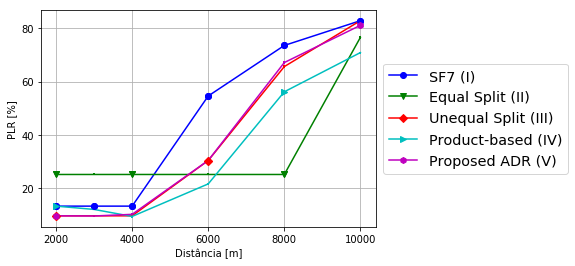

/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


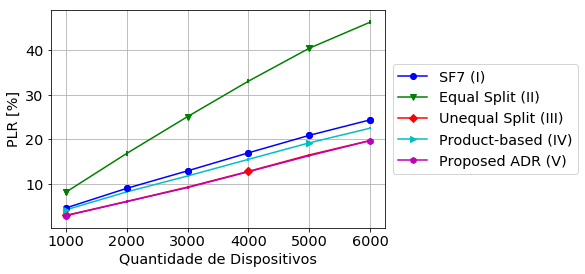

/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


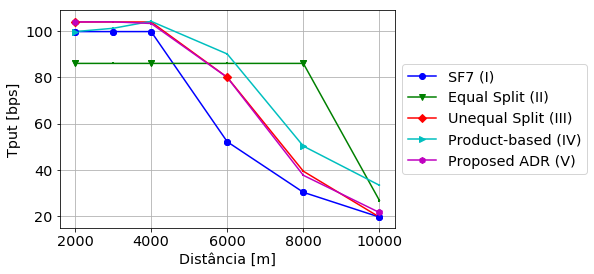

/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


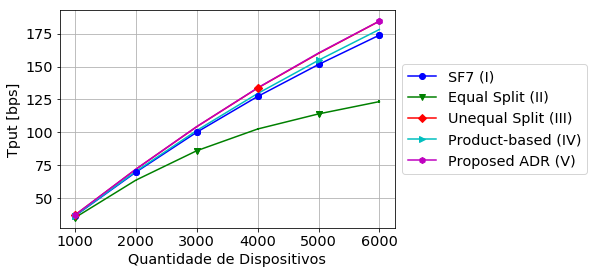

/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


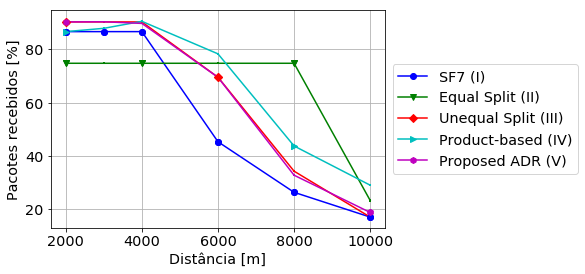

/home/gppcom/2020_1/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


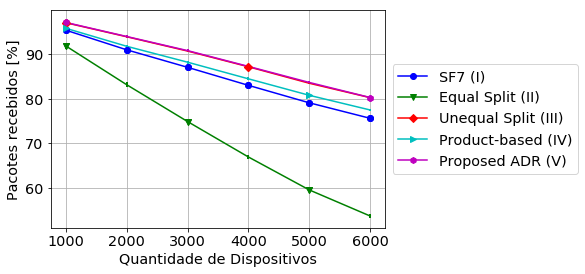

In [12]:
%run plotScript -f "ADR_campaign.yaml"

É possível abservar que o intervalo de confiana já é bem pequeno para 20 jobs.